## <ins> Configuration Parameters </ins>
Every experiment needs some control parameters, so here is a basic way to initialize them and prepare them for development. **The most important parameters for running this tutorial are the following:**


- `path_results`: path to results folder


- `path_datasets` : path to dataset folder

Note this configuration setup also supports Nvidia GPU acceleration. However, make sure that you have an environment that supports GPU driver and CUDA. 

In [1]:
# Author: MINDFUL
# Purpose: Configuration ( Linear Regression )

#--------------------------------
# Parameters: All Paths (I / O)
#--------------------------------

path_results = "../../results/mlp/"
path_dataset = "../../data/classification/data.csv"

#-------------------------------
# Parameters: Training Model
#-------------------------------

# Config: Validation Rate

valid_rate = 1

# Config: Randomization

seed = 123 

# Config: CPU 

num_workers = 1

# Config: GPU

use_gpu = 0
gpu_list = [0, 1]

# Config: Gradient Descent

batch_size = 16
num_epochs = 50 
learning_rate = 0.01

# Config: Logger 
# - 0 : Tensorboard
# - 1 : Custom Logger

logger_choice = 0

# Create: Parameter Container 

params = { "path_results": path_results, "path_dataset": path_dataset,
           "valid_rate": valid_rate, "seed": seed, "num_workers": num_workers, "use_gpu": use_gpu, 
           "gpu_list": gpu_list, "batch_size": batch_size, "num_epochs": num_epochs, "learning_rate": learning_rate }


## <ins> Verbose Warnings </ins>

Pytorch lightning is notorious of its warnings. Some can be helpful during the debugging process. Others can be things like suggestions to improve performance. B/c of this, going to share how to filter them. 

In [2]:
#--------------------------------
# Remove: Irrelevant Warnings
#--------------------------------

import warnings

warnings.filterwarnings("ignore")

## <ins> Python Libraries </ins> 

Big strength of python is its large library support. Lets import some and discuss their importance. 

**Standard Libraries**

- `warnings`: Controls i/o with respect to warnings


- `numpy`: Linear algebra, data representation (e.g., matrices, vectors), and more


- `matplotlib`: Visualizations / Plots


- `torch`: the original pytorch, a modern library for nerual network applications. 


- `pytorch_lightning`: Pytorch but with more tools that support organization and simplification. There are a lot of libraries to important, and in a later tutorial we will explore their importance. However, for now, treat as magic!


**Custom Libraries** ( I made these - not discussed in this tutorial, but feel free to take a look! )


- Loader: Convert dataset to pytorch format


- Logger: Experiment logging tool for results



In [3]:
#--------------------------------
# Import: Basic Python Libraries
#--------------------------------

import warnings
import numpy as np
import matplotlib.pyplot as plt

#--------------------------------
# Import: Pytorch Libraries
#--------------------------------

import torch
import torch.nn as nn

from typing import Optional
from torch.utils.data import DataLoader
from pytorch_lightning.plugins import DDPPlugin
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.utilities import rank_zero_only
from pytorch_lightning.loggers import LightningLoggerBase
from pytorch_lightning.loggers.base import rank_zero_experiment
from pytorch_lightning import LightningModule, LightningDataModule

#--------------------------------
# Import: Custom Python Libraries
#--------------------------------

from custom_logger import Logger
from loader import Dataset as Pytorch_Dataset


## <ins> Dataset Loader </ins>

First thing to do is write a loader for our dataset. We are using .csv files in the following format:


- **rows** : observation samples of dataset


- **columns** : features of observation samples **(last column is supervised label of observation sample)**.

**Code Breakdown:**


- `Dataset`: basic way to represent a dataset ( observed samples, labels )


- `load_data()`: load a .csv file with the aforementioned format. 
   

In [4]:
#--------------------------------
# Initialize: Custom Dataset 
#--------------------------------

class Dataset:

    def __init__(self, samples, labels):

        self.labels = labels
        self.samples = samples

#--------------------------------
# Load: Training Dataset (.CSV)
#--------------------------------

def load_data(path):

    data_file = open(path, "r")

    data = []
    for line in data_file:
        data.append([ float(ele.strip("\n")) for ele in line.split(",") ])

    data = np.asarray(data)

    samples, labels = data[:, :-1], data[:, -1]

    return Dataset(samples, labels)


## <ins> Dataset Preview </ins>

Lets take a quick look at the dataset to see what we are trying to solve

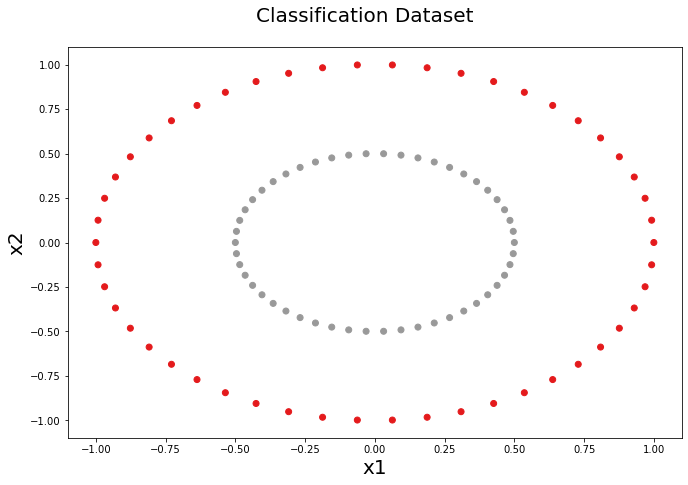

In [5]:
def show_data(dataset, f_s = 20, p_s = (11, 7)):
    
    samples, labels = dataset.samples, dataset.labels 
    
    fig, ax = plt.subplots(figsize = p_s)
    
    ax.scatter(samples[:, 0], samples[:, 1], c = labels, cmap = "Set1")
    
    ax.set_xlabel("x1", fontsize = f_s)
    ax.set_ylabel("x2", fontsize = f_s)

    fig.suptitle("Classification Dataset", fontsize = f_s)

    plt.subplots_adjust(top = 0.90)
    
    plt.show()

dataset = load_data(path_dataset)
show_data(dataset)

## <ins> Pytorch Lightning Dataset </ins>

Pytorch lightning shines when using a dataloader (i.e., a specific format for a dataset). The dataloader bestows benefits like implicit shuffling, mini-batch sample support, improved cpu parallelization. 

Because of this lets make a **Pytorch Lightning Data Module (PLDM)** that takes a dataset and converts it into a pytorch dataloader. This is requires two steps:

- Convert basic dataset to pytorch dataset. Specifically, I provide code for this ( please take a look if you're interested. Not too difficult ), but will not go into detail for this tutorial unless asked!


- Convert pytorch dataset to pytorch dataloader. 

**Code Breakdown:**


- `PLDM`: our pytorch lightning class that converts a dataset into pytorch format. 


- `setup()`: method that converts dataset into pytorch dataset. Note for this method, we don't have a validation dataset so we are instead doing re-substitution (i.e., evaluating on the training dataset). 


- `train_dataloader()`, `val_dataloader()`: methods that converts pytorch datasets into pytorch dataloaders



In [6]:
#--------------------------------
# Create: Lightning Data Module
#--------------------------------

class PLDM(LightningDataModule):

    def __init__(self, params):
        
        super().__init__() 
                           
        # Load: Dataset Parameters
                           
        self.data = params["train"]
                           
        # Load: Processing Parameters

        self.batch = params["batch_size"]
        self.workers = params["num_workers"]
        
    #----------------------------
    # Create: Training Datasets 
    #----------------------------
                           
    def setup(self, stage: Optional[str] = None):

        # Create: Pytorch Datasets

        self.train = Pytorch_Dataset(self.data)
        self.valid = Pytorch_Dataset(self.data)

    #----------------------------
    # Create: Training DataLoader
    #----------------------------

    def train_dataloader(self):

        return DataLoader( self.train, batch_size = self.batch,
                           num_workers = self.workers, shuffle = 1, persistent_workers = 1 )

    #----------------------------
    # Create: Validation Loader
    #----------------------------

    def val_dataloader(self):

        return DataLoader( self.valid, batch_size = self.batch,
                           num_workers = self.workers, persistent_workers = 1 )


## <ins> Pytorch Lightning Model </ins>

Pytorch is a neural network framework. So any models we design using it follow a very similar structure:

- **Architecture** : Topology of the network in layers where each layer can have a set of optimizable parameters


- **Objective Function** : Function representing the error of the goal the network is trying to perform. 


- **Optimization Function** : Function representing how the model updates its parameters (e.g, flavors of gradient descent)


**Code Breakdown:**


- `Linear_Regression`: our pytorch class for implementing the linear regression algorithm


- `objective()`: method that defines objective function of the model. Specifically for this example we use Mean Squared Error (MSE). 


- `configure_optimizers()`: method that defines optimization paradigm for learning. Specifcally for this example we use a variation of gradient descent called Adaptive Momentum Estimation (ADAM). 


- `forward()`: method that defines calculations leading to model prediciton. 


- `training_step()`: method that defines how the training dataset interacts with the model. The training step includes: **(Forward pass)** Data is fed to the model and the model undergoes calculations leading to make a prediciton. **(Error Assessment)** the model prediciton is compared to a truth label and error is calculated to guide learning. **(Backwards pass)** the models learnable paremters are updated using the objective loss. It is important to note that this section of code explictly shows the forward pass and objective loss calculations. However, the backwards pass is handed through auto-differentiation implicitly. 


- `training_epoch_end()`: method that defines any addtional logging / algorithms / assessments that you want to run after a complete training cycle (epoch)


- `validation_step()`: method that defines how the validation dataset intereacts with the model. 


- `validation_epoch_end()`: logging / algorithms / assessments that you want to run after a complete vdalidation cycle. I personally find this useful for recording performance metrics (e.g., precision, accuracy, recall) or other visualizations (e.g., learned feature embeddings, learned weights, generated imagery). 


- `calculate_performance()`: method that creates a confusion matrix with respect to truth labels and model predictions



- `calculate_statistics()`: function that calculates precision, recall, and accuracy performance metrics.



- `prepare_world()`: method that creates and evaluates 2D feature space 

- `log_features()`: method that illustrates learned decision boundary and saves via tensorboard


In [7]:
#--------------------------------
# Import: Basic Python Libraries
#--------------------------------

import torch
import numpy as np
import torch.nn as nn                                                                      

from pytorch_lightning import LightningModule

#--------------------------------
# Initialize: Lightining Model
#--------------------------------

class MLP(LightningModule):

    def __init__(self, params):

        super().__init__()

        # Load: Model Parameters
        
        self.max_epochs = params["num_epochs"]
        self.learning_rate = params["learning_rate"]

        # Initialize: MLP Model 

        self.evaluate = nn.Sequential( nn.Linear(2, 5),
                                       nn.ReLU(),
                                       nn.Linear(5, 10),
                                       nn.ReLU(),
                                       nn.Linear(10, 2) )

    #----------------------------
    # Create: Objective Function
    #----------------------------

    def objective(self, preds, labels):
    
        # Format: Labels

        labels = labels.long()

        # Objective: Mean Squared Error

        cost = nn.CrossEntropyLoss() 

        loss = cost(preds, labels) 

        # Logging: Loss

        self.log("loss", loss, on_step = True, on_epoch = True)

        return loss

    #----------------------------
    # Create: Optimizer Function
    #----------------------------

    def configure_optimizers(self):

        optimizer = torch.optim.Adam(self.parameters(), lr = self.learning_rate)

        return optimizer

    #----------------------------
    # Create: Model Forward Pass
    #----------------------------

    def forward(self, samples):

        return self.evaluate(samples)

    #----------------------------
    # Create: Train Cycle (Epoch)
    #----------------------------

    def training_step(self, batch, batch_idx):

        # Load: Data Batch

        samples, labels = batch

        preds = self(samples)

        # Calculate: Training Loss

        loss = self.objective(preds, labels)
       
        return loss

    #----------------------------
    # Run: Post Training Script
    #----------------------------

    def training_epoch_end(self, train_step_outputs): 

        # Update: Training Plots

        if(logger_choice == 1):
            
            if(self.current_epoch > 0):

                logger = self.logger.experiment

                logger.log_training_loss(self.current_epoch)

                # Finalize: Learned Features & Metrics ( Video )

                if(self.current_epoch == self.max_epochs - 1):

                    logger.finalize_results()

    #----------------------------
    # Create: Validation Cycle 
    #----------------------------

    def validation_step(self, batch, batch_idx):

        samples, labels = batch

        preds = self(samples)
    
        return samples, labels, preds

    #----------------------------
    # Run: Post Validation Script
    #----------------------------

    def validation_epoch_end(self, val_step_outputs): 

        # Organize: Validation Outputs
 
        all_samples, all_labels, all_preds = [], [], []
    
        for group in val_step_outputs:

            samples, labels, preds = group

            all_labels.append( labels )
            all_samples.append( samples )
            all_preds.append( preds.detach() )

        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        all_samples = torch.cat(all_samples)

        # Calculate: Performance

        results = self.calculate_performance(all_preds, all_labels)

        # Logger: Performance

        self.log("recall", results["model_recall"], on_epoch = True)
        self.log("accuracy", results["model_accuracy"], on_epoch = True)
        self.log("precision", results["model_precision"], on_epoch = True)
        
        preds, feature_space = self.prepare_world(all_samples)
            
        if(self.current_epoch > 0):
            
            if(logger_choice == 0):
                
                # Logger: Feature Visualizations  
                
                self.log_features(all_samples, all_labels, feature_space, preds, self.current_epoch)
                
            else:
                    
                logger = self.logger.experiment

                # Logger: Validation Plots

                logger.log_valid_results(self.current_epoch)

                # Logger: Feature Visualizations  

                logger.log_features(all_samples, all_labels, feature_space, preds, self.current_epoch)

    #----------------------------
    # Run: Validation Metrics
    #----------------------------

    def calculate_performance(self, all_preds, all_labels):

        unique_labels = np.unique(all_labels.numpy())

        confusion_matrix = np.zeros( [len(unique_labels), len(unique_labels)] )

        for pred, label in zip(all_preds, all_labels):

            label = int(label)

            prediction = np.argmax(pred.numpy())
            
            confusion_matrix[label][prediction] += 1                
               
        confusion_matrix = confusion_matrix.astype(int)        
     
        return calculate_statistics(confusion_matrix)

    #----------------------------
    # Generation: Feature Space
    #----------------------------
    
    def prepare_world(self, samples, offset = 0.5, precision = 0.05):

        # Gather: Mins, Maxes Dataset ( Adjust Offset )

        y_min = torch.min(samples[:, 0]) - offset
        y_max = torch.max(samples[:, 0]) + offset
        x_min = torch.min(samples[:, 1]) - offset
        x_max = torch.max(samples[:, 1]) + offset

        # Create: 2D Feature Space 
    
        y_vals = torch.arange(y_min, y_max, precision)
        x_vals = torch.arange(x_min, x_max, precision)

        all_points = [ [y, x] for y in y_vals for x in x_vals ]

        all_points = torch.tensor(all_points)

        # Evaluate: 2D Feature Space ( MLP )

        predictions = []
        for sample in all_points:
            
            sample = torch.unsqueeze(sample, dim = 0)
            predictions.append( torch.argmax(self(sample).detach()) )
            
        return torch.tensor(predictions), all_points

    #----------------------------
    # Logging: Feature Embeddings
    #----------------------------

    def log_features(self, samples, labels, feature_space, preds, epoch, z = 4, f_s = 20, p_s = (15, 11)):

        # Assign: Figure Name

        name = "features.png"

        # Format: Plot

        plt.style.use("seaborn")

        # Assign: Colors

        face_colors = [ "blue" if(ele == 0) else "red" for ele in labels ]
        back_colors = [ "darkblue" if(ele == 0) else "darkred" for ele in preds ]

        # Plot: Dataset & Feature Space

        fig, ax = plt.subplots(figsize = p_s)

        ax.scatter( feature_space[:, 0], feature_space[:, 1], c = back_colors )
        ax.scatter( samples[:, 0], samples[:, 1], s = 200, 
                    linewidths = 3, edgecolor = "black", c = face_colors )

        ax.set_xlabel("x1", fontsize = f_s)
        ax.set_ylabel("x2", fontsize = f_s)

        fig.suptitle("Learned Decision Boundary", fontsize = f_s)

        plt.subplots_adjust(top = 0.90)
      
        logger = self.logger.experiment
        logger.add_figure(name,  plt.gcf(), global_step = epoch)


In [8]:
#----------------------------
# Calculate: Basic Statistics
#----------------------------

def calculate_statistics(matrix):

    results = {}
    all_precision, all_recall, all_fscore, all_accuracy = [], [], [], []

    for target_class in range(matrix.shape[0]):

        true_positive = matrix[target_class, target_class]
        false_negatives = np.sum(matrix[target_class, :] ) - true_positive
        false_positives = np.sum(matrix[:, target_class] ) - true_positive

        if(true_positive != 0):            
            precision = true_positive / ( true_positive + false_positives ) 
            recall = true_positive / ( true_positive + false_negatives ) 
            fscore = ( 2 * recall * precision ) / ( recall + precision )
            accuracy = true_positive / np.sum(matrix[target_class, : ])
        else:
            precision = recall = fscore = accuracy = 0

        all_precision.append(np.round(precision, 3))
        all_accuracy.append(np.round(accuracy, 3))
        all_fscore.append(np.round(fscore, 3))
        all_recall.append(np.round(recall, 3))

    results['model_precision'] = np.round(np.mean(all_precision), 3)
    results['model_accuracy'] = np.round(np.mean(all_accuracy), 3)
    results['model_recall'] = np.round(np.mean(all_recall), 3)
    results['model_fscore'] = np.round(np.mean(all_fscore), 3)

    results['class_precision'] = all_precision
    results['class_accuracy'] = all_accuracy
    results['class_recall'] = all_recall
    results['class_fscore'] = all_fscore 

    results['confusion'] = matrix

    return results 

## <ins> Pytorch Lightning Trainer </ins>

Lastly, we just need a **Pytorch Lightning Trainer** that will take the **Pytorch Dataset and Model** and begin a training process. We also put everything together that we initialized above in the code section below. 

In [9]:
# Initialize: Gloabl Seed

seed_everything(seed, workers = True)

# Generate: Synthetic Dataset
     
dataset = load_data(path_dataset)
        
params["train"] = dataset
    
# Initialize: Formatter

dataset = PLDM(params)

# Initialize: Model

model = MLP(params)

# Initialize: Logger 

if(logger_choice == 0):
    logger = pl_loggers.TensorBoardLogger(path_results, name = "", version = 0)
else:
    logger = Logger(path_results, name = "", version = 0)

# Train: Model

if(use_gpu):

    # Initialize: GPU Trainer

    trainer = Trainer( logger = logger,
                       deterministic = True,
                       default_root_dir = path_results,
                       check_val_every_n_epoch = valid_rate,
                       max_epochs = num_epochs, num_nodes = 1,
                       num_sanity_val_steps = 0, gpus = gpu_list,
                       plugins = DDPPlugin(find_unused_parameters=False, ) )
else:

    # Initialize: CPU Trainer

    trainer = Trainer( logger = logger,
                       deterministic = True,
                       max_epochs = num_epochs,
                       num_sanity_val_steps = 0,
                       default_root_dir = path_results,
                       check_val_every_n_epoch = valid_rate )

trainer.fit(model, dataset)


Global seed set to 123
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name     | Type       | Params
----------------------------------------
0 | evaluate | Sequential | 97    
----------------------------------------
97        Trainable params
0         Non-trainable params
97        Total params
0.000     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]